# Modelo B para clasificación de imagenes

#### Jeffrey Daniel Leiva Cascante 2021016720
#### Richard Osvaldo León Chinchilla carnet

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Propuesta de modelo 1

In [5]:
class InceptionModuleOne(nn.Module):
  def __init__(self, chanels):
    super(InceptionModuleOne, self).__init__()

    self.branch1 = nn.Conv2d(chanels, 128, kernel_size=1)

    self.branch2 = nn.Sequential(
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.Conv2d(128, 128, kernel_size=3, padding=1)
    )

    self.branch3 = nn.Sequential(
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.Conv2d(128, 128, kernel_size=5, padding=2)
    )

    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(chanels, 128, kernel_size=1)
    )

  def forward(self,x):
    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)
    return torch.cat([branch1, branch2, branch3, branch4],1)


class CNNModelBOne(nn.Module):
  def __init__(self):
    super(CNNModelBOne, self).__init__()
    self.conv1 = nn.Conv2d(1, 64, 3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.inception = InceptionModuleOne(64)
    self.dropout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(512 *32 *32, 128)
    self.fc2 = nn.Linear(128 , 3)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.inception(x)
    x = self.pool(x)
    x = self.dropout(x)
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x



Proof of Concept modelo 1

In [17]:
train_data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.RandomRotation(20),  # Rotación aleatoria
    transforms.RandomHorizontalFlip(),  # Inversión horizontal aleatoria
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Variación de brillo y contraste
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización
])


test_data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ToTensor(),   # Convertir a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización
])


# Definir las rutas a las carpetas
train_dir = '/content/drive/MyDrive/Covid19-dataset/train'
test_dir = '/content/drive/MyDrive/Covid19-dataset/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_data_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_data_transforms)

# Definir el tamaño del subconjunto que quieres usar
subset_size = 0.35  # Por ejemplo, usar el 20% de los datos

# Obtener los índices aleatorios para el subconjunto del conjunto de entrenamiento
np.random.seed(42)
train_size = len(train_dataset)
indices = list(range(train_size))
np.random.shuffle(indices)  # Mezclar los índices

subset_indices = indices[:int(subset_size * train_size)]  # Obtener el subconjunto

# Crear un SubsetRandomSampler con los índices seleccionados
train_sampler = SubsetRandomSampler(subset_indices)

# Obtener los índices aleatorios para el subconjunto del conjunto de testing
test_size = len(test_dataset)
indices_test = list(range(test_size))
np.random.shuffle(indices_test)  # Mezclar los índices

subset_indices_test = indices_test[:int(subset_size * test_size)]  # Obtener el subconjunto

# Crear un SubsetRandomSampler con los índices seleccionados
test_sampler = SubsetRandomSampler(subset_indices_test)

# Definir DataLoader para el conjunto de entrenamiento con el subconjunto de datos
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)

# También puedes crear un DataLoader para el conjunto de prueba completo
test_loader = DataLoader(test_dataset, batch_size=32, sampler=test_sampler)


model = CNNModelBOne()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Definir la función de entrenamiento
def train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()  # Poner el modelo en modo de entrenamiento

        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Limpiar los gradientes
            outputs = model(inputs)  # Hacer una predicción
            loss = criterion(outputs, labels)  # Calcular la pérdida
            loss.backward()  # Hacer backpropagation
            optimizer.step()  # Actualizar los pesos

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Disable gradients for validation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_running_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Train the model with validation
train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=30)





Epoch 1/30, Train Loss: 1.0910, Train Accuracy: 39.08%, Val Loss: 1.0801, Val Accuracy: 34.78%
Epoch 2/30, Train Loss: 0.9975, Train Accuracy: 45.98%, Val Loss: 0.9603, Val Accuracy: 47.83%
Epoch 3/30, Train Loss: 0.8292, Train Accuracy: 85.06%, Val Loss: 0.8599, Val Accuracy: 60.87%
Epoch 4/30, Train Loss: 0.6833, Train Accuracy: 80.46%, Val Loss: 0.8169, Val Accuracy: 56.52%
Epoch 5/30, Train Loss: 0.5964, Train Accuracy: 80.46%, Val Loss: 0.7358, Val Accuracy: 69.57%
Epoch 6/30, Train Loss: 0.5490, Train Accuracy: 85.06%, Val Loss: 0.7159, Val Accuracy: 65.22%
Epoch 7/30, Train Loss: 0.4655, Train Accuracy: 82.76%, Val Loss: 0.8396, Val Accuracy: 56.52%
Epoch 8/30, Train Loss: 0.4168, Train Accuracy: 87.36%, Val Loss: 0.6565, Val Accuracy: 78.26%
Epoch 9/30, Train Loss: 0.4044, Train Accuracy: 88.51%, Val Loss: 0.7439, Val Accuracy: 60.87%
Epoch 10/30, Train Loss: 0.3347, Train Accuracy: 89.66%, Val Loss: 0.7768, Val Accuracy: 56.52%
Epoch 11/30, Train Loss: 0.2773, Train Accuracy: 

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
tensor([1, 1, 0, 0, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 0, 0, 2, 1, 0, 2, 1, 2, 1])


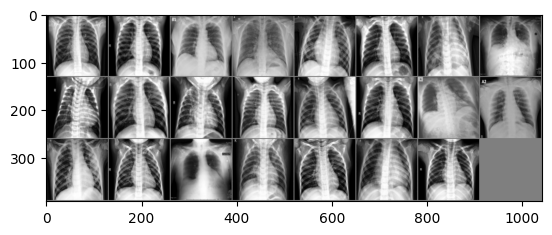

GroundTruth
Normal
Normal
Covid
Covid
Viral Pneumonia
Normal
Viral Pneumonia
Covid
Viral Pneumonia
Normal
Viral Pneumonia
Normal
Viral Pneumonia
Normal
Covid
Covid
Viral Pneumonia
Normal
Covid
Viral Pneumonia
Normal
Viral Pneumonia
Normal


In [18]:
classes = ('Covid', 'Normal','Viral Pneumonia')

#Para ver com se asignan las etiquetas a cada clase en el set de training
print(train_dataset.class_to_idx)
#Lo mismo pero para el set de testing
print(test_dataset.class_to_idx)

dataiter = iter(test_loader)
images, labels = next(dataiter)

print(labels)

def imshow(img):
    # Desnormalizar: (img * std) + mean
    img = img * 0.5 + 0.5  # Desnormalizar usando mean=0.5 y std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # Añadir cmap si es necesario
    plt.show()

imshow(torchvision.utils.make_grid(images))

print('GroundTruth')
for j in range(23):
    print(f'{classes[labels[j]]:5s}')

In [25]:
images = images.to(device)  # Mueve las imágenes a la GPU si está disponible

outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ')

for j in range(23):
    print(f'{classes[predicted[j]]:5s}')


Predicted: 
Viral Pneumonia
Viral Pneumonia
Normal
Normal
Normal
Normal
Covid
Normal
Normal
Viral Pneumonia
Viral Pneumonia
Covid
Viral Pneumonia
Covid
Viral Pneumonia
Normal
Viral Pneumonia
Covid
Normal
Viral Pneumonia
Normal
Viral Pneumonia
Covid


In [30]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 23 test images: {100 * correct // total} %')

Accuracy of the network on the 23 test images: 78 %


In [ ]:
import os

# Listar el contenido de la carpeta Covid19
os.listdir('/content/drive/MyDrive/Covid19-dataset')